# Temporal RSA

This demo notebook demonstrates how to work with temporal data in the RSA toolbox


So far, it demonstrates how to

(1) import temporal dataset into the `pyrsa.data.TemporalDataset` class and 

(2) how to create RDM movies using the `pyrsa.rdm.calc_rdm_movie` function

The notebook will 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyrsa
import pickle

from pyrsa.rdm import calc_rdm_movie

## Load temporal data

I here used sample data from mne-python

https://mne.tools/dev/overview/datasets_index.html#sample

Data is comprised of the preprocessed MEG data in "sample_audvis_raw.fif".

Preprocessing includes:
- downsampling to 60Hz 
- band-pass filtering between 1 Hz and 20 Hz
- rejecting bad trials using an amplitude threshold
- baseline correction (basline -200 to 0 ms)

*See demos/TemporalSampleData/preproc_mn_sample_data.py*

The preprocessed data is stored in *TemporalSampleData/meg_sample_data.pkl*

In [2]:
dat = pickle.load( open( "TemporalSampleData/meg_sample_data.pkl", "rb" ) )
measurements = dat['data']
cond_names = [x for x in dat['cond_names'].keys()]
cond_idx = dat['cond_idx']
channel_names = dat['channel_names']
times = dat['times']

In [3]:
print('there are %d observations (trials), %d channels, and %d time-points\n' % 
      (measurements.shape))

print('conditions:')
print(cond_names)

there are 227 observations (trials), 203 channels, and 58 time-points

conditions:
['Auditory/Left', 'Auditory/Right', 'Visual/Left', 'Visual/Right']


Plot condition averages for two channels:

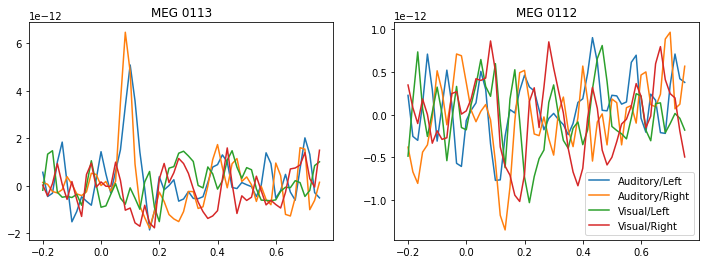

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax = ax.flatten()
for jj,chan in enumerate(channel_names[:2]):
    for ii, cond_ii in enumerate(np.unique(cond_idx)):
        mn = measurements[cond_ii == cond_idx,jj,:].mean(0).squeeze()
        ax[jj].plot(times, mn, label = cond_names[ii])
        ax[jj].set_title(chan)
ax[jj].legend()
plt.show()

## The `pyrsa.data.TemporalDataset` class

`measurements` is an `np.array` of shape n_obs x n_channels x n_times

`time_descriptor` should contain the time-point vector for the measurements of length n_times. it is recommended to call this descriptor 'time'

In [5]:
tim_des = {'time': times}

the other descriptors are identical as in the `pyrsa.data.Dataset` class

In [6]:
des = {'session': 0, 'subj': 0}
obs_des = {'conds': cond_idx}
chn_des = {'channels': channel_names}

In [7]:
data = pyrsa.data.TemporalDataset(measurements, 
                              descriptors = des, 
                              obs_descriptors = obs_des, 
                              channel_descriptors = chn_des, 
                              time_descriptors = tim_des)
data.sort_by('conds')

### convenience methods

`pyrsa.data.TemporalDataset` comes with the same convenience methods as `pyrsa.data.Dataset`.

In addition, the following functions are provided:

- `pyrsa.data.TemporalDataset.split_time(by)`
- `pyrsa.data.TemporalDataset.subset_time(by, t_from, t_to)`
- `pyrsa.data.TemporalDataset.bin_time(by, bins)`
- `pyrsa.data.TemporalDataset.convert_to_dataset(by)`

#### `pyrsa.data.TemporalDataset.split_time(by)`

splits the `pyrsa.data.TemporalDataset` object into a list of n_times `pyrsa.data.TemporalDatset` objects, splitting the measurements along the time_descriptor `by`

In [8]:
print('shape of original measurements')
print(data.measurements.shape)

data_split_time = data.split_time('time')

print('\nafter splitting')
print(len(data_split_time))
print(data_split_time[0].measurements.shape)

shape of original measurements
(227, 203, 58)

after splitting
58
(227, 203, 1)


#### `pyrsa.data.TemporalDataset.subset_time(by, t_from, t_to)`

returns a new `pyrsa.data.TemporalDataset` with only the data between where `time_descriptors[by]` is between t_from and t_to

In [9]:
print('shape of original measurements')
print(data.measurements.shape)

data_subset_time = data.subset_time('time', t_from = -.1, t_to = .5)

print('\nafter subsetting')
print(data_subset_time.measurements.shape)
print(data_subset_time.time_descriptors['time'][0])

shape of original measurements
(227, 203, 58)

after subsetting
(227, 203, 37)
-0.09989760657919393


#### `pyrsa.data.TemporalDataset.bin_time(by, bins)`

returns a new `pyrsa.data.TemporalDataset` object with binned temporal data. data within bins is averaged.

`bins` is a list or array, where the first dimension contains the bins, and the second dimension the old time-bins that should go into this bin. 

In [10]:
bins = np.reshape(tim_des['time'], [-1, 2])
print(len(bins))
print(bins[0])

29
[-0.19979521 -0.18314561]


In [11]:
print('shape of original measurements')
print(data.measurements.shape)

data_binned = data.bin_time('time', bins=bins)

print('\nafter binning')
print(data_binned.measurements.shape)
print(data_binned.time_descriptors['time'][0])

shape of original measurements
(227, 203, 58)

after binning
(227, 203, 29)
-0.1914704126101217


#### `pyrsa.data.TemporalDataset.convert_to_dataset(by)`

returns a `pyrsa.data.Dataset` object where the time dimension is absorbed into the observation dimension

In [12]:
print('shape of original measurements')
print(data.measurements.shape)

data_dataset = data.convert_to_dataset('time')

print('\nafter binning')
print(data_dataset.measurements.shape)
print(data_dataset.obs_descriptors['time'][0])

shape of original measurements
(227, 203, 58)

after binning
(13166, 203)
-0.19979521315838786


## create RDM movie

the function `calc_rdm_movie` takes `pyrsa.data.TemporalDataset` as an input and outputs an RDMs `pyrsa.rdm.RDMs` object.
It works like `calc_rdm`.

In [13]:
rdms_data = calc_rdm_movie(data, method = 'euclidean', 
                           descriptor = 'conds')
print(rdms_data)

pyrsa.rdm.RDMs
58 RDM(s) over 4 conditions

dissimilarity_measure = 
euclidean

dissimilarities[0] = 
[[0.00000000e+00 4.48201826e-25 6.17620803e-25 4.68172301e-25]
 [4.48201826e-25 0.00000000e+00 7.16414642e-25 4.27861898e-25]
 [6.17620803e-25 7.16414642e-25 0.00000000e+00 7.61554453e-25]
 [4.68172301e-25 4.27861898e-25 7.61554453e-25 0.00000000e+00]]

descriptors: 
session = 0
subj = 0

rdm_descriptors: 
index = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57]
time = [-0.19979521 -0.18314561 -0.16649601 -0.14984641 -0.13319681 -0.11654721
 -0.09989761 -0.08324801 -0.0665984  -0.0499488  -0.0332992  -0.0166496
  0.          0.0166496   0.0332992   0.0499488   0.0665984   0.08324801
  0.09989761  0.11654721  0.13319681  0.14984641  0.16649601  0.18314561
  0.19979521  0.21644481  0.23309442  0.24974402  0.26639362  0.28304322
  0.29969282  0.31634242  0.33299

Binning can be applied before computing the RDMs by simpling specifying the bins argument

In [14]:
rdms_data_binned = calc_rdm_movie(data, method = 'euclidean', 
                           descriptor = 'conds',
                           bins=bins)
print(rdms_data_binned)

pyrsa.rdm.RDMs
29 RDM(s) over 4 conditions

dissimilarity_measure = 
euclidean

dissimilarities[0] = 
[[0.00000000e+00 3.46836229e-25 4.81401601e-25 3.27640005e-25]
 [3.46836229e-25 0.00000000e+00 4.35938622e-25 3.20443252e-25]
 [4.81401601e-25 4.35938622e-25 0.00000000e+00 5.22469051e-25]
 [3.27640005e-25 3.20443252e-25 5.22469051e-25 0.00000000e+00]]

descriptors: 
session = 0
subj = 0

rdm_descriptors: 
index = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28]
time = [-0.19147041 -0.15817121 -0.12487201 -0.09157281 -0.0582736  -0.0249744
  0.0083248   0.041624    0.0749232   0.10822241  0.14152161  0.17482081
  0.20812001  0.24141922  0.27471842  0.30801762  0.34131682  0.37461602
  0.40791523  0.44121443  0.47451363  0.50781283  0.54111204  0.57441124
  0.60771044  0.64100964  0.67430884  0.70760805  0.74090725]

pattern_descriptors: 
index = [0 1 2 3]
conds = [1.0, 2.0, 3.0, 4.0]




## from here on

The following are examples for data analysis and plotting with temporal data. So far it uses the functions for non-temporal data of the toolbox. This section should be expanded once new temporal RSA functions are added to the toolbox.

I here use plotting from the standard plotting function.

C:\Users\Benjamin\.conda\envs\pyrsa\lib\site-packages\pyrsa\vis\rdm_plot.py:42: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(n, m, idx + 1)
C:\Users\Benjamin\.conda\envs\pyrsa\lib\site-packages\pyrsa\vis\rdm_plot.py:47: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(n, m, n * m)


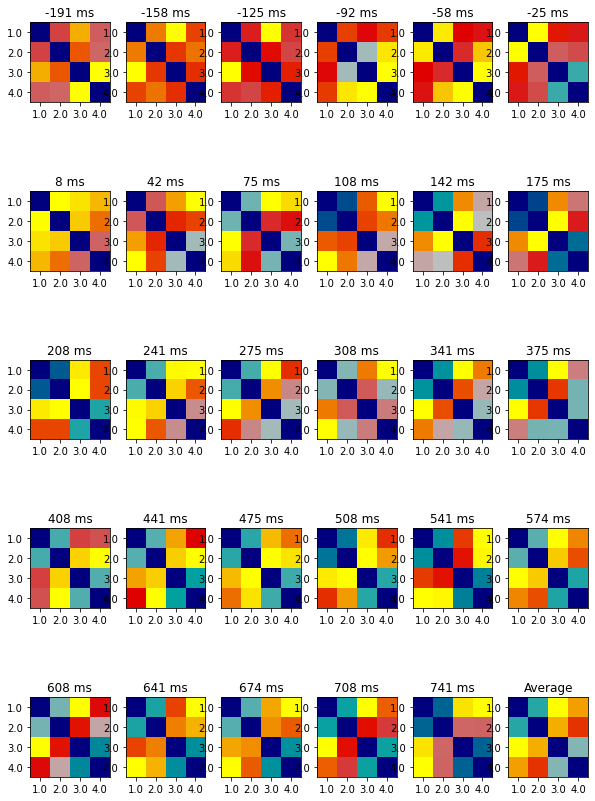

In [15]:
plt.subplots(1, figsize=(10,15))

# add formated time as rdm_descriptor
rdms_data_binned.rdm_descriptors['time_formatted'] = ['%0.0f ms' % (np.round(x*1000,2)) for x in rdms_data_binned.rdm_descriptors['time']]

pyrsa.vis.show_rdm(rdms_data_binned, 
                   do_rank_transform=False, 
                   pattern_descriptor='conds',
                   rdm_descriptor='time_formatted')

## Model rdms

This is a simple example with basic model RDMs

In [16]:
from pyrsa.rdm import get_categorical_rdm

In [17]:
rdms_model_in = get_categorical_rdm(['%d' % x for x in range(4)])
rdms_model_lr = get_categorical_rdm(['l','r','l','r'])
rdms_model_av = get_categorical_rdm(['a','a','v','v'])

model_names = ['independent', 'left/right', 'audio/visual']

# append in one RDMs object

model_rdms = rdms_model_in
model_rdms.append(rdms_model_lr)
model_rdms.append(rdms_model_av)

model_rdms.rdm_descriptors['model_names'] = model_names
model_rdms.pattern_descriptors['cond_names'] = cond_names

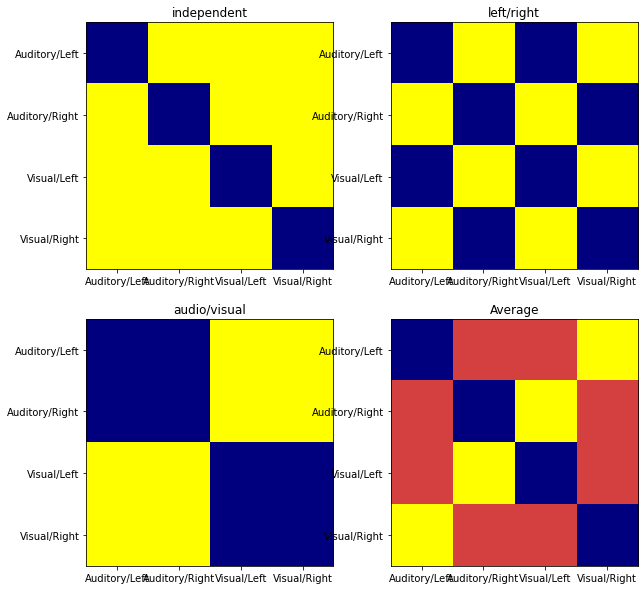

In [18]:
plt.figure(figsize=(10,10))
pyrsa.vis.show_rdm(model_rdms, rdm_descriptor='model_names', pattern_descriptor = 'cond_names')

## data - model similarity across time

In [19]:
from pyrsa.rdm import compare

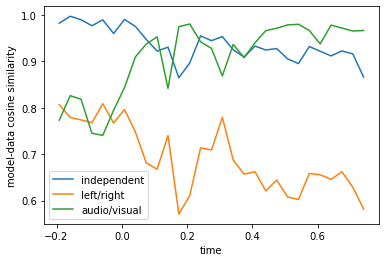

In [20]:
r = []
for mod in model_rdms:
    r.append(compare(mod, rdms_data_binned, method='cosine'))

for i, r_ in enumerate(r):
    plt.plot(rdms_data_binned.rdm_descriptors['time'], r_.squeeze(), label=model_names[i])

plt.xlabel('time')
plt.ylabel('model-data cosine similarity')
plt.legend()